# Clustering neighborhoods in New Orleans via the Foursquare API

We cluster neighborhoods in New Orleans, as identified from Wikipedia, relative to the frequencies of venue categories in each neighborhood as determined by calls to the Foursquare Places API.  The clustering is performed by using SciKit-Learn's k-means clustering algorithm on a OneHot encoding of the above data.  We particularly wish to identify those neighborhoods similar in character to the popular French Quarter in downtown New Orleans.

## Part 1: Scrape Wikipedia for NOLA Neighborhoods

In [1]:
#Import relavant packages

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import lxml.html as lh # library to handle html parsing

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [2]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [3]:
#Establish datascraping url
url = 'https://en.wikipedia.org/wiki/Neighborhoods_in_New_Orleans'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

Everything in the table on wikipedia is between <tr> and </tr> markers in html; let's extract this info.

In [4]:
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Verify that tr_elements rows have same length
#[len(T) for T in tr_elements[:]]

Looks like the last seven rows of our data tr_elements are from other tables; let's drop them.

In [5]:
tr_elements = tr_elements[:len(tr_elements)-7]

#[len(T) for T in tr_elements[:]]

Let's see what we've scraped:

In [6]:
#Check the output of the first row
tr_elements[0].text_content()

'\nNeighborhood\n\nLongitude\n\nLatitude\n'

We will now scrape the information in the table.

In [7]:
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    #Extract text content from each row element, removing the extra line break \n.
    name=t.text_content().replace('\n','')
    print('%d:"%s"'%(i,name))
    col.append((name,[]))

1:"Neighborhood"
2:"Longitude"
3:"Latitude"


In [8]:
for j in range(1,len(tr_elements)):
    #T is our jth row
    T=tr_elements[j]
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content().replace('\n','')
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Now let's convert the data col into a dictionary, and then into a dataframe.

In [9]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [10]:
df

,Neighborhood,Longitude,Latitude
0,U.S. NAVAL BASE,-90.02609253,29.94608469
1,ALGIERS POINT,-90.0516057,29.95246187
2,WHITNEY,-90.04235744,29.94720026
3,AUDUBON,-90.12145042,29.93299437
4,OLD AURORA,-90,29.92444011
5,B. W. COOPER,-90.09175301,29.95177397
6,BAYOU ST. JOHN,-90.08651733,29.97607064
7,BEHRMAN,-90.02643585,29.9348167
8,BLACK PEARL,-90.13488293,29.93589521
9,BROADMOOR,-90.10381222,29.9465681


In [11]:
df.shape

(72, 3)

We need to ensure that the coordinate data are floats rather than strings:

In [12]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

## Part 2: Explore and cluster NOLA neighborhoods

Find the central latitude and longitude for NOLA:

In [13]:
address = 'New Orleans, Louisiana, United States'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of New Orleans are {}, {}.'.format(latitude, longitude))

The geographical coordinates of New Orleans are 29.9499323, -90.0701156.


Create a map of Toronto with our neighborhoods superimposed on top:

In [14]:
# create map of New Orleans using latitude and longitude values
map_NOLA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NOLA)  
    
map_NOLA

Some of these neighborhoods (VIAVANT - VENETIAN ISLES, VILLAGE DE LEST, LAKE CATHERINE, NEW AURORA - ENGLISH TURN) are well outside the city limits and not reasonable places to consider opening a restaurant; let's remove them from consideration:

In [15]:
nbhd_to_drop = ['VIAVANT - VENETIAN ISLES', 'VILLAGE DE LEST', 'LAKE CATHERINE', 'NEW AURORA - ENGLISH TURN']

for nbhd in nbhd_to_drop:
    df = df[df['Neighborhood'] != nbhd]

Let's visualize the map again without the outlier neighborhoods:

In [16]:
# create map of New Orleans using latitude and longitude values
map_NOLA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NOLA)  
    
map_NOLA

Much better.  Now let's use the Foursquare API to find some information about local venues in these neighborhoods.

In [17]:
# Input personal Foursquare credentials (please don't steal these!)

CLIENT_ID = 'PZTWCA4DG2GN0SB25BKQESAVATQJ33V3GYPTDU5KPS3RZ2JN' # Foursquare ID
CLIENT_SECRET = 'JCCKWNWGRF5HAQJDQLWJDNY5DLL1UZ5YBZRZOGZWKMYCGDS4' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Recall the functions which 1) extract the venue category type from Foursquare data, and 2) get venue data for a given neighborhood:

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's get the nearby venues for each collection of neighborhoods associated to the postal codes:

In [19]:
NOLA_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

U.S. NAVAL BASE
ALGIERS POINT
WHITNEY
AUDUBON
OLD AURORA
B. W. COOPER
BAYOU ST. JOHN
BEHRMAN
BLACK PEARL
BROADMOOR
MARLYVILLE - FONTAINEBLEAU
GERT TOWN
MID-CITY
ST. CLAUDE
CENTRAL BUSINESS DISTRICT
FRENCH QUARTER
CENTRAL CITY
TALL TIMBERS - BRECHTEL
FISCHER DEV
McDONOGH
LOWER GARDEN DISTRICT
ST. THOMAS DEV
EAST RIVERSIDE
IRISH CHANNEL
TOURO
MILAN
UPTOWN
WEST RIVERSIDE
EAST CARROLLTON
FRERET
GARDEN DISTRICT
LEONIDAS
HOLLYGROVE
TULANE - GRAVIER
TREME - LAFITTE
SEVENTH WARD
MARIGNY
ST. ROCH
DIXON
LAKEWOOD
NAVARRE
CITY PARK
LAKEVIEW
WEST END
LAKESHORE - LAKE VISTA
FILMORE
ST. BERNARD AREA
DILLARD
ST.   ANTHONY
LAKE TERRACE & OAKS
MILNEBURG
PONTCHARTRAIN PARK
GENTILLY WOODS
GENTILLY TERRACE
DESIRE AREA
FLORIDA AREA
FLORIDA DEV
LOWER NINTH WARD
BYWATER
HOLY CROSS
PINES VILLAGE
PLUM ORCHARD
READ BLVD WEST
READ BLVD EAST
WEST LAKE FOREST
LITTLE WOODS
FAIRGROUNDS
IBERVILLE


In [20]:
NOLA_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,U.S. NAVAL BASE,29.946085,-90.026093,The Mighty Missisippi,29.949695,-90.023710,Boat or Ferry
1,ALGIERS POINT,29.952462,-90.051606,Tout de Suite Café,29.952121,-90.051090,Café
2,ALGIERS POINT,29.952462,-90.051606,Congregation Coffee Roasters,29.951918,-90.053395,Coffee Shop
3,ALGIERS POINT,29.952462,-90.051606,The Crown & Anchor,29.951416,-90.054220,Bar
4,ALGIERS POINT,29.952462,-90.051606,Old Point Bar,29.954940,-90.050226,Bar


In [21]:
NOLA_venues.groupby('Neighborhood').count()['Venue Category']

Neighborhood
ALGIERS POINT                  23
AUDUBON                         9
B. W. COOPER                    5
BAYOU ST. JOHN                  7
BLACK PEARL                     4
BROADMOOR                       5
BYWATER                        12
CENTRAL BUSINESS DISTRICT     100
CENTRAL CITY                    6
CITY PARK                       6
DESIRE AREA                     1
DILLARD                         6
DIXON                           6
EAST CARROLLTON                28
EAST RIVERSIDE                 25
FAIRGROUNDS                    14
FILMORE                         6
FISCHER DEV                     1
FLORIDA AREA                    2
FRENCH QUARTER                100
FRERET                         36
GARDEN DISTRICT                55
GENTILLY TERRACE                3
GENTILLY WOODS                  4
GERT TOWN                       5
HOLLYGROVE                      3
HOLY CROSS                      5
IBERVILLE                      22
IRISH CHANNEL                   8
L

Compute the number of unique venue categories:

In [22]:
print('There are {} unique categories.'.format(len(NOLA_venues['Venue Category'].unique())))

There are 206 unique categories.


Let's onehot encode our venue data and perform k-means clustering:

In [23]:
first_col = NOLA_venues['Neighborhood']

# one hot encoding
NOLA_onehot = pd.get_dummies(NOLA_venues[['Venue Category']], prefix="", prefix_sep="")
NOLA_onehot.pop('Neighborhood')

# add neighborhood column back to dataframe as the first column 
col_name = 'Neighborhood'
NOLA_onehot.insert(0,col_name,first_col)

NOLA_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Apres Ski Bar,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Lake,Light Rail Station,Lounge,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Nightlife Spot,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,RV Park,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Skate Park,Smoke Shop,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Stables,Steakhouse,Street Art,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,U.S. NAVAL BASE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ALGIERS POINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ALGIERS POINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Group data by the neighborhood:

In [24]:
NOLA_grouped = NOLA_onehot.groupby('Neighborhood').mean().reset_index()
NOLA_grouped

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Apres Ski Bar,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Lake,Light Rail Station,Lounge,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Nightlife Spot,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,RV Park,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Skate Park,Smoke Shop,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Stables,Steakhouse,Street Art,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,ALGIERS POINT,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.043478,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.130435,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130435,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.043478,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000,0.00,0.000

Print each neighborhood and their top 3 venues:

In [25]:
num_top_venues = 3

for hood in NOLA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NOLA_grouped[NOLA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALGIERS POINT----
            venue  freq
0             Bar  0.13
1   Boat or Ferry  0.13
2  Scenic Lookout  0.09


----AUDUBON----
                   venue  freq
0          Smoothie Shop  0.11
1  Outdoors & Recreation  0.11
2  College Arts Building  0.11


----B. W. COOPER----
               venue  freq
0  Recreation Center   0.2
1         Boxing Gym   0.2
2         Food Truck   0.2


----BAYOU ST. JOHN----
                  venue  freq
0     Convenience Store  0.14
1           Gas Station  0.14
2  Other Great Outdoors  0.14


----BLACK PEARL----
           venue  freq
0     Food Truck  0.25
1          Plaza  0.25
2  Grocery Store  0.25


----BROADMOOR----
               venue  freq
0  Recreation Center   0.2
1        Music Venue   0.2
2         Food Truck   0.2


----BYWATER----
           venue  freq
0  Indie Theater  0.08
1  Boat or Ferry  0.08
2    Coffee Shop  0.08


----CENTRAL BUSINESS DISTRICT----
       venue  freq
0      Hotel  0.17
1        Bar  0.06
2  Hotel Bar  0.06


Create a pandas dataframe from this information:

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NOLA_grouped['Neighborhood']

for ind in np.arange(NOLA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NOLA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,ALGIERS POINT,Boat or Ferry,Bar,Scenic Lookout
1,AUDUBON,Outdoors & Recreation,Smoothie Shop,Sandwich Place
2,B. W. COOPER,Gym / Fitness Center,Recreation Center,Boxing Gym
3,BAYOU ST. JOHN,Sandwich Place,Convenience Store,Playground
4,BLACK PEARL,Food Truck,Plaza,Farmers Market
5,BROADMOOR,Music Venue,Recreation Center,Coffee Shop
6,BYWATER,Indie Theater,Coffee Shop,Boat or Ferry
7,CENTRAL BUSINESS DISTRICT,Hotel,Hotel Bar,Coffee Shop
8,CENTRAL CITY,Park,Cajun / Creole Restaurant,Grocery Store
9,CITY PARK,Baseball Field,Trail,Tennis Court


Now let's perform k-means on the data.  We will use the "elbow method" to determine the optimal value of k.

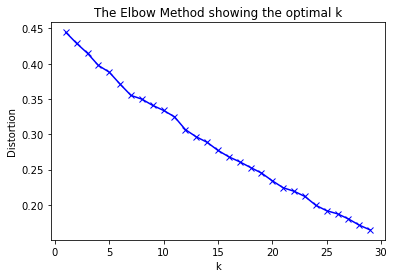

In [27]:
#Drop the neighborhood column (which we do not want to train our clusters to):
NOLA_grouped_clustering = NOLA_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(NOLA_grouped_clustering)
    distortions.append(sum(np.min(cdist(NOLA_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / NOLA_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Unfortunately there is no apparent elbow in the above graph; the closest things to elbows occur at k = 5, 8, and 21.  21 clusters is likely too many for a data set of size < 100, so let's use k = 8.

In [28]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NOLA_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted['Cluster Labels'] = neighborhoods_venues_sorted['Cluster Labels'].astype(int)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
NOLA_merged = df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#NOLA_merged['Cluster Labels'] = NOLA_merged['Cluster Labels'].astype(int)

In [29]:
NOLA_merged.dropna(axis = 0, inplace=True)
NOLA_merged['Cluster Labels'] = NOLA_merged['Cluster Labels'].astype(int)

Remap the neighborhoods, colored according to their label from the k-means clustering algorithm:

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NOLA_merged['Latitude'], NOLA_merged['Longitude'], NOLA_merged['Neighborhood'], NOLA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Notice that the clusters often are a single neighborhood -- this phenomenon was exacerbated with fewer clusters.  In fact, with a bit of trial and error, I discovered that distinguishing the downtown neighborhoods (like the French Quarter and Central Business Districts) from the neighborhoods in, e.g., Uptown/Mid-City, required more than 30 clusters! 

## 2.1 A more refined attempt at clustering:

Given the apparent homogeneity of the central city in New Orleans, I would like to continue removing some of the outlying neighborhoods and focus strictly on the Uptown/Mid-City/French Quarter areas.  To this end, let's remove the neighborhoods outside of these regions and see if we find more interesting clusters:

In [31]:
df2 = df
nbhd_to_drop2 = ['LAKEWOOD','NAVARRE','ST.   ANTHONY','FAIRGROUNDS', 'ST. ROCH', 'FLORIDA DEV', 'FLORIDA AREA','ST. CLAUDE','DILLARD','MILNEBURG', 'GENTILLY TERRACE', 'PONTCHARTRAIN PARK', 'GENTILLY WOODS', 'DESIRE AREA','LAKESHORE - LAKE VISTA','WEST END','LAKEVIEW','CITY PARK','ST. BERNARD AREA','FILMORE', 'LAKE TERRACE & OAKS', 'U.S. NAVAL BASE','BEHRMAN','TALL TIMBERS - BRECHTEL', 'OLD AURORA', 'FISCHER DEV', 'ALGIERS POINT', 'McDONOGH', 'WHITNEY', 'HOLY CROSS', 'LOWER NINTH WARD', 'BYWATER', 'PINES VILLAGE', 'PLUM ORCHARD', 'WEST LAKE FOREST', 'READ BLVD WEST', 'READ BLVD EAST', 'LITTLE WOODS']

for nbhd in nbhd_to_drop2:
    df2 = df2[df2['Neighborhood'] != nbhd]
    
# create map of New Orleans using latitude and longitude values
map_NOLA2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NOLA2)  
    
map_NOLA2

In [32]:
NOLA_venues2 = getNearbyVenues(names=df2['Neighborhood'],latitudes=df2['Latitude'],longitudes=df2['Longitude'])

AUDUBON
B. W. COOPER
BAYOU ST. JOHN
BLACK PEARL
BROADMOOR
MARLYVILLE - FONTAINEBLEAU
GERT TOWN
MID-CITY
CENTRAL BUSINESS DISTRICT
FRENCH QUARTER
CENTRAL CITY
LOWER GARDEN DISTRICT
ST. THOMAS DEV
EAST RIVERSIDE
IRISH CHANNEL
TOURO
MILAN
UPTOWN
WEST RIVERSIDE
EAST CARROLLTON
FRERET
GARDEN DISTRICT
LEONIDAS
HOLLYGROVE
TULANE - GRAVIER
TREME - LAFITTE
SEVENTH WARD
MARIGNY
DIXON
IBERVILLE


In [33]:
first_col2 = NOLA_venues2['Neighborhood']

# one hot encoding
NOLA_onehot2 = pd.get_dummies(NOLA_venues2[['Venue Category']], prefix="", prefix_sep="")
NOLA_onehot2.pop('Neighborhood')

# add neighborhood column back to dataframe as the first column 
col_name2 = 'Neighborhood'
NOLA_onehot2.insert(0,col_name2,first_col2)

NOLA_grouped2 = NOLA_onehot2.groupby('Neighborhood').mean().reset_index()

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = NOLA_grouped2['Neighborhood']

for ind in np.arange(NOLA_grouped2.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(NOLA_grouped2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,AUDUBON,Coffee Shop,Light Rail Station,College Arts Building
1,B. W. COOPER,Food Truck,Home Service,Recreation Center
2,BAYOU ST. JOHN,Playground,Gas Station,Park
3,BLACK PEARL,Plaza,Farmers Market,Grocery Store
4,BROADMOOR,Taco Place,Coffee Shop,Recreation Center
5,CENTRAL BUSINESS DISTRICT,Hotel,Bar,Coffee Shop
6,CENTRAL CITY,Park,Cajun / Creole Restaurant,Fried Chicken Joint
7,DIXON,Pharmacy,Warehouse Store,Food Court
8,EAST CARROLLTON,Sandwich Place,Coffee Shop,Café
9,EAST RIVERSIDE,Clothing Store,Cocktail Bar,Middle Eastern Restaurant


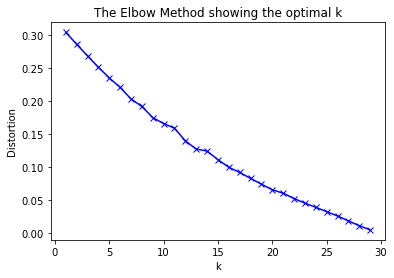

In [34]:
#Drop the neighborhood column (which we do not want to train our clusters to):
NOLA_grouped_clustering2 = NOLA_grouped2.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(NOLA_grouped_clustering2)
    distortions.append(sum(np.min(cdist(NOLA_grouped_clustering2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / NOLA_grouped_clustering2.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Alas, once again we find no real elbow in the plot other than perhaps a slight one at k = 6 or 9.

In [35]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NOLA_grouped_clustering2)

# add clustering labels
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted2['Cluster Labels'] = neighborhoods_venues_sorted2['Cluster Labels'].astype(int)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
NOLA_merged2 = df2.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')

NOLA_merged2.dropna(axis = 0, inplace=True)
NOLA_merged2['Cluster Labels'] = NOLA_merged2['Cluster Labels'].astype(int)

In [36]:
# create map
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NOLA_merged2['Latitude'], NOLA_merged2['Longitude'], NOLA_merged2['Neighborhood'], NOLA_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

Once again, our clusters are not so interesting: we have 6 clusters, 5 of which consist of single neighborhoods.  This is surprising; one would expect the neighborhoods downtown to distinguish themselves from those uptown with relatively few clusters.

## 2.2 But really, can we distinguish between downtown and uptown?

The failure of the k-means clustering algorithm to usefully cluster neighborhoods which are fundamentally different suggests that the Foursquare API venues grouped in too specific a manner:

In [37]:
NOLA_venues2.groupby('Venue Category')['Venue'].count()

Venue Category
Accessories Store                            4
American Restaurant                          8
Antique Shop                                 5
Arcade                                       1
Art Gallery                                  4
Arts & Crafts Store                          1
Asian Restaurant                             4
Athletics & Sports                           1
Automotive Shop                              1
BBQ Joint                                    1
Bagel Shop                                   1
Bakery                                       7
Bank                                         3
Bar                                         50
Bed & Breakfast                              4
Beer Garden                                  3
Beer Store                                   1
Big Box Store                                1
Bike Rental / Bike Share                     2
Bistro                                       1
Bookstore                                    

Out of curiosity, let's eliminate those venues which are completely unique (i.e., venues whose venue category appears only once in the dataframe):

In [38]:
NOLA_venues3 = NOLA_venues2[NOLA_venues2.groupby('Venue Category')['Venue Category'].transform('size') > 1].reset_index(drop=True)
NOLA_venues3

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AUDUBON,29.932994,-90.121450,Audubon Park Entrance Pavilion,29.934449,-90.123710,Plaza
1,AUDUBON,29.932994,-90.121450,Starbucks,29.933688,-90.121603,Coffee Shop
2,AUDUBON,29.932994,-90.121450,Smoothie King,29.936202,-90.120401,Smoothie Shop
3,AUDUBON,29.932994,-90.121450,Subway,29.936220,-90.120124,Sandwich Place
4,AUDUBON,29.932994,-90.121450,St. Charles Streetcar - Tulane/Loyola,29.934210,-90.122468,Light Rail Station
5,AUDUBON,29.932994,-90.121450,Upper Audubon,29.934816,-90.126094,Park
6,B. W. COOPER,29.951774,-90.091753,C Food Roam A Lot,29.954078,-90.089341,Food Truck
7,B. W. COOPER,29.951774,-90.091753,ChillTek AC Repair New Orleans,29.948061,-90.093543,Home Service
8,B. W. COOPER,29.951774,-90.091753,Crescent City Boxig Gym,29.948676,-90.088503,Gym / Fitness Center
9,B. W. COOPER,29.951774,-90.091753,Rosenwald Community Center,29.954374,-90.095913,Recreation Center


Once more, with feeling:

In [39]:
first_col3 = NOLA_venues3['Neighborhood']

# one hot encoding
NOLA_onehot3 = pd.get_dummies(NOLA_venues3[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe as the first column 
col_name3 = 'Neighborhood'
NOLA_onehot3.insert(0,col_name3,first_col3)

NOLA_grouped3 = NOLA_onehot3.groupby('Neighborhood').mean().reset_index()

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted3 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted3['Neighborhood'] = NOLA_grouped3['Neighborhood']

for ind in np.arange(NOLA_grouped3.shape[0]):
    neighborhoods_venues_sorted3.iloc[ind, 1:] = return_most_common_venues(NOLA_grouped3.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,AUDUBON,Smoothie Shop,Park,Coffee Shop
1,B. W. COOPER,Home Service,Gym / Fitness Center,Recreation Center
2,BAYOU ST. JOHN,Playground,Convenience Store,Park
3,BLACK PEARL,Plaza,Grocery Store,Farmers Market
4,BROADMOOR,Food Truck,Coffee Shop,Recreation Center
5,CENTRAL BUSINESS DISTRICT,Hotel,Hotel Bar,Coffee Shop
6,CENTRAL CITY,Park,Fried Chicken Joint,Grocery Store
7,DIXON,Smoothie Shop,Thrift / Vintage Store,Food Court
8,EAST CARROLLTON,Coffee Shop,Café,Sandwich Place
9,EAST RIVERSIDE,Clothing Store,Middle Eastern Restaurant,Taco Place


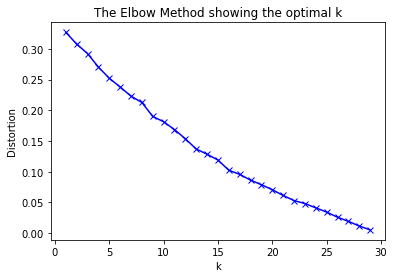

In [40]:
#Drop the neighborhood column (which we do not want to train our clusters to):
NOLA_grouped_clustering3 = NOLA_grouped3.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(NOLA_grouped_clustering3)
    distortions.append(sum(np.min(cdist(NOLA_grouped_clustering3, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / NOLA_grouped_clustering3.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Potential elbow at k = 12:

In [41]:
# set number of clusters
kclusters = 12

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NOLA_grouped_clustering3)

# add clustering labels
neighborhoods_venues_sorted3.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted3['Cluster Labels'] = neighborhoods_venues_sorted3['Cluster Labels'].astype(int)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
NOLA_merged3 = df2.join(neighborhoods_venues_sorted3.set_index('Neighborhood'), on='Neighborhood')

NOLA_merged3.dropna(axis = 0, inplace=True)
NOLA_merged3['Cluster Labels'] = NOLA_merged3['Cluster Labels'].astype(int)

In [42]:
# create map
map_clusters3 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NOLA_merged3['Latitude'], NOLA_merged3['Longitude'], NOLA_merged3['Neighborhood'], NOLA_merged3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters3)
       
map_clusters3

With 12 clusters we have finally managed to distinguish downtown New Orleans from uptown New Orleans.  However, there are only 30 neighborhoods to cluster, so even this distinction is perhaps not so useful.

Interestingly, the Touro neighborhood is clustered with the French Quarter and Central Business District, which indicates it may be a potential place of interest for investing in a new business.